https://www.katnoria.com/mdn/

TF 2.0 example

In [21]:
# Add required imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

In [22]:
# Example presented in the PRML book
def create_book_example(n=1000):
    # sample uniformly over the interval (0,1)
    X = np.random.uniform(0., 1., (n,1)).astype(np.float32)    
    # target values 
    y = X + 0.3 * np.sin(2 * np.pi * X) + np.random.uniform(-0.1, 0.1, size=(n,1)).astype(np.float32)
    # test data
    x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)    
    return X, y, x_test

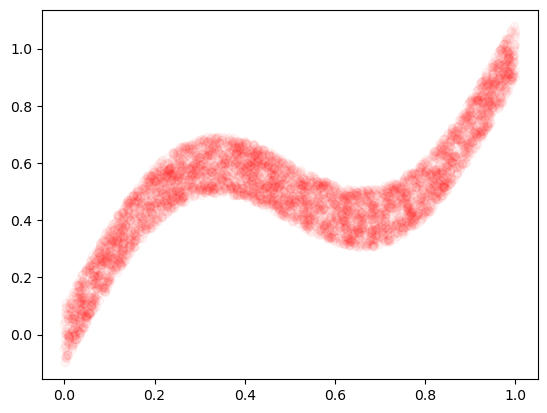

In [23]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=4000)
plt.plot(X, y, 'ro', alpha=0.04)
plt.show()

In [24]:
# Load Tensorflow
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from copy import deepcopy ## Shouldn't need this anymore

In [25]:
tf.__version__

'2.16.1'

In [26]:
# Is GPU Available
tf.config.list_physical_devices('GPU')

[]

In [27]:
tf.executing_eagerly()

True

## Inverse problem



In [28]:
# print data shape
print(X.shape, y.shape)

#flipped_x = deepcopy(y)
#flipped_y = deepcopy(X)
flipped_x = y
flipped_y = X

(4000, 1) (4000, 1)


## Mixture density network

In MDNs, instead of modeling the input (x) -> target (y) mapping by explicitly generating the output values, we learn the probability distribution of each target and sample the predicted output $\hat{y}$ from that distribution. The distribution itself is represented by several gaussians (i.e a mixture of gaussians), which are able to represent a complex distribution.

For every input x, we learn the distribution parameters namely mean, variance and mixing coefficient. In terms of total output values, there are $(l+2)k$ values where $k$ is the number of gaussians and $l$ is the number of input features. The breakdown of output values is shown below:

- Mixing coefficient ($\pi$): $k$
- Variance ($\sigma^2$): $k$
- Mean ($\mu$): $l \times k$

MDN provides a generic framework for modeling conditional probability distribution using a linear combination of mixing coefficient and respective component densities:

$$
p(y|x) = \sum_k \pi_k(x) \mathcal{N} (y|\mu_k(x), \sigma^2_k(x))
$$

In [29]:
# In our toy example, we have single input feature
l = 1
# Number of gaussians to represent the multimodal distribution
k = 26

# Network
input = tf.keras.Input(shape=(l,))
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)
mu = tf.keras.layers.Dense((l * k), activation=None, name='mean_layer')(layer)
# variance (should be greater than 0 so we exponentiate it)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
# mixing coefficient should sum to 1.0
pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)

In [30]:
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ baselayer (Dense)   │ (None, 50)        │        100 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_var_layer     │ (None, 26)        │      1,326 │ baselayer[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pi_layer (Dense)    │ (None, 26)        │      1,326 │ baselayer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_layer (Dense)  │ (None, 26)        │      1,326 │ baselayer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variance_layer      │ (None, 26)        │          0 │ dense_var_layer[… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,078 (15.93 KB)

 Trainable params: 4,078 (15.93 KB)

 Non-trainable params: 0 (0.00 B)

The loss function with respect to component weights w is given by

$$
L(w) = \frac{-1}{N} \sum_{n=1}^N log(\sum_k \pi_k(x_n, w)\mathcal{N}(y_n|\mu_k(x_n,w),\sigma^2(x_n,w)))
$$

The component density is given by

$$
f(x) = \frac{e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2 \pi \sigma^2}}
$$

In [31]:
# Take a note how easy it is to write the loss function in 
# new tensorflow eager mode (debugging the function becomes intuitive too)

def calc_pdf(y, mu, var):
    """Calculate component density"""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value


def mdn_loss(y_true, pi, mu, var):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
    out = calc_pdf(y_true, mu, var)
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

Lets verify whether our implementation is correct by comparing the values with numpy version

In [32]:
calc_pdf(np.array([3.0]), np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3])).numpy()

array([0.00443185, 0.03977444, 0.06695205])

In [33]:
# Numpy version
def pdf_np(y, mu, var):
    n = np.exp((-(y-mu)**2)/(2*var))
    d = np.sqrt(2 * np.pi * var)
    return n/d
print('Numpy version: ')
pdf_np(3.0, np.array([0.0, 0.1, 0.2]), np.array([1.0, 2.2, 3.3]))

Numpy version: 


array([0.00443185, 0.03977444, 0.06695205])

In [34]:
loss_value = mdn_loss(
    np.array([3.0, 1.1]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]).reshape(2,-1).astype('float64'), 
    np.array([[0.0, 0.1, 0.2], [0.0, 0.1, 0.2]]).reshape(2,-1).astype('float64'), 
    np.array([[1.0, 2.2, 3.3], [1.0, 2.2, 3.3]]).reshape(2,-1).astype('float64')
).numpy()

assert np.isclose(loss_value, 3.4714, atol=1e-5), 'MDN loss incorrect'

In [35]:
# Use Dataset API to load numpy data (load, shuffle, set batch size)
N = flipped_x.shape[0]
N = 1000
dataset = tf.data.Dataset \
    .from_tensor_slices((flipped_x, flipped_y)) \
    .shuffle(N).batch(N)

In [36]:
@tf.function
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [37]:
# Define model and optimizer
#model = tf.keras.models.Model(input, [pi, mu, var])
#optimizer = tf.keras.optimizers.Adam()
#for tx, ty in dataset:
#    print("1")
#    #print(tx)
#    #print(ty)
#    loss = train_step(model, optimizer, tx, ty)
#    print(f"tmp {loss}")

#print(loss)

In [38]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [39]:
ty

<tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
array([[0.3192912 ],
       [0.6991065 ],
       [0.08883601],
       [0.450055  ],
       [0.7660434 ],
       [0.51725286],
       [0.28901693],
       [0.6293938 ],
       [0.2628859 ],
       [0.23379374],
       [0.84492207],
       [0.6271419 ],
       [0.637954  ],
       [0.679665  ],
       [0.51102006],
       [0.55636215],
       [0.52056164],
       [0.2133726 ],
       [0.83737713],
       [0.9530157 ],
       [0.22848873],
       [0.88347423],
       [0.33539665],
       [0.9220731 ],
       [0.49227083],
       [0.29457757],
       [0.9698576 ],
       [0.61688185],
       [0.85469884],
       [0.2566278 ],
       [0.4401439 ],
       [0.5696928 ],
       [0.03566673],
       [0.781424  ],
       [0.29578716],
       [0.0866527 ],
       [0.46238732],
       [0.60503465],
       [0.42765084],
       [0.675242  ],
       [0.47473574],
       [0.9721497 ],
       [0.97358716],
       [0.77195567],
       [0.04169286],
    

In [40]:
losses = []
EPOCHS = 6000
print_every = int(0.1 * EPOCHS)

# Define model and optimizer
model = tf.keras.models.Model(input, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))  

Print every 600 epochs


2025-01-23 20:24:02.774230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.781317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.788062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.794714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.801052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.806819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.813208: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 0/6000: loss 1.0940171480178833


2025-01-23 20:24:02.983113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.991583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:02.999551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:03.007355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:03.014925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:03.021609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:03.028570: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 600/6000: loss -1.017035961151123


2025-01-23 20:24:07.734146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.742311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.751011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.759233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.766983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.774827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:07.783221: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1200/6000: loss -1.0327321290969849


2025-01-23 20:24:12.685335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.692117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.699534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.707244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.714433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.721393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:12.728118: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1800/6000: loss -1.0859274864196777


2025-01-23 20:24:17.212452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.219177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.227037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.233826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.240976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.248440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:17.255080: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 2400/6000: loss -1.0587894916534424


2025-01-23 20:24:21.936703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.945269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.953893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.962366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.970704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.978659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:21.986366: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 3000/6000: loss -1.0803900957107544


2025-01-23 20:24:26.461655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.469563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.476841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.484116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.491152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.498215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:26.505200: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 3600/6000: loss -1.1143443584442139


2025-01-23 20:24:30.993944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.002464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.010412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.018790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.027245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.035405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:31.043994: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 4200/6000: loss -1.09787917137146


2025-01-23 20:24:35.940916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:35.951319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:35.967074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:35.976426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:35.985619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:35.994442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:36.004775: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 4800/6000: loss -1.0969549417495728


2025-01-23 20:24:40.659873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.666996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.674424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.682143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.689355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.698253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:40.705752: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 5400/6000: loss -1.0986183881759644


2025-01-23 20:24:45.160957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.168396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.176692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.183908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.191033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.198104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-23 20:24:45.205384: W tensorflow/core/framework/local_rendezvous.cc:404] L

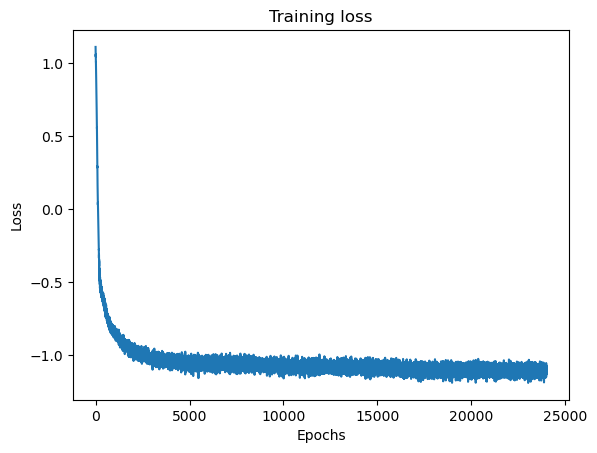

In [41]:
# Let's plot the training loss
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


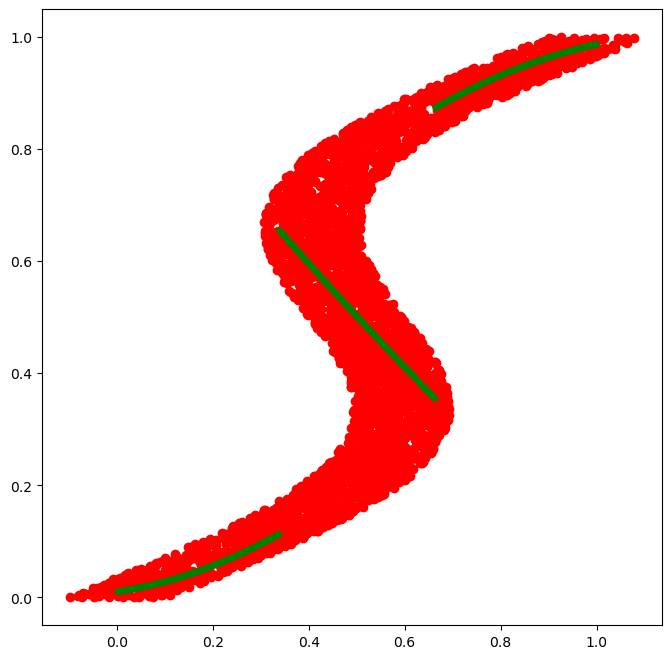

In [42]:
def approx_conditional_mode(pi, var, mu):
    """Approx conditional mode
    Because the conditional mode for MDN does not have simple analytical
    solution, an alternative is to take mean of most probable component 
    at each value of x (PRML, page 277)
    """
    n, k = pi.shape
    out = np.zeros((n, l))
    # Get the index of max pi value for each row
    max_component = tf.argmax(pi, axis=1)
    for i in range(n):
        # The mean value for this index will be used
        mc = max_component[i].numpy()
        for j in range(l):
            out[i, j] = mu[i, mc*(l+j)]
    return out


# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)
pi_vals.shape, mu_vals.shape, var_vals.shape

# Get mean of max(mixing coefficient) of each row
preds = approx_conditional_mode(pi_vals, var_vals, mu_vals)

# Plot along with training data
fig = plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro')
plt.plot(x_test, preds, 'g.')
# plt.plot(flipped_x, preds2, 'b.')
plt.show()

In [43]:
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    # print('shape: ', n, k, l)
    # place holder to store the y value for each sample of each row
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            # for each sample, use pi/probs to sample the index
            # that will be used to pick up the mu and var values
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                # Draw random sample from gaussian distribution
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out    

sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 10)

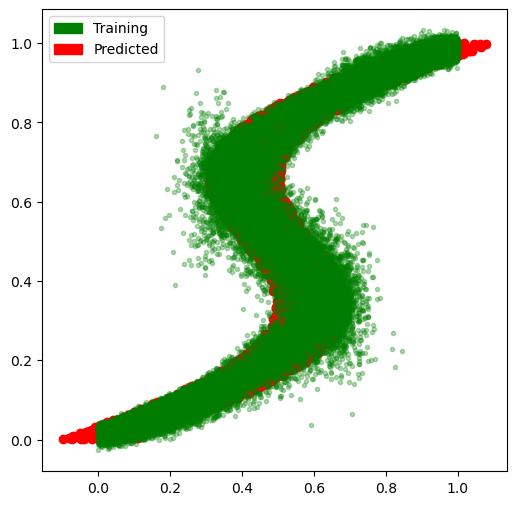

In [44]:
# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(x_test, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]

plt.legend(handles=patches)
plt.show()

In [45]:
pi_vals.shape

(4000, 26)

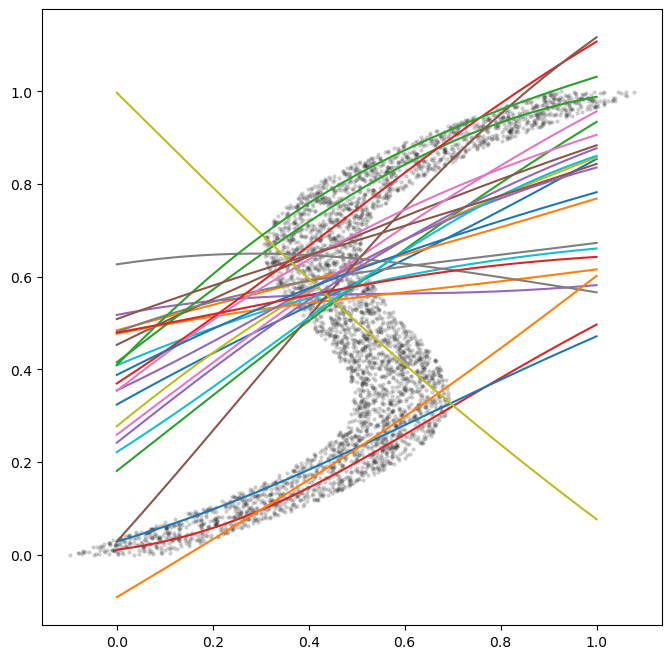

In [46]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_vals.T, var_vals.T):
    plt.plot(x_test, mu_k)
    # plt.fill_between(x_test, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(flipped_x, flipped_y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()

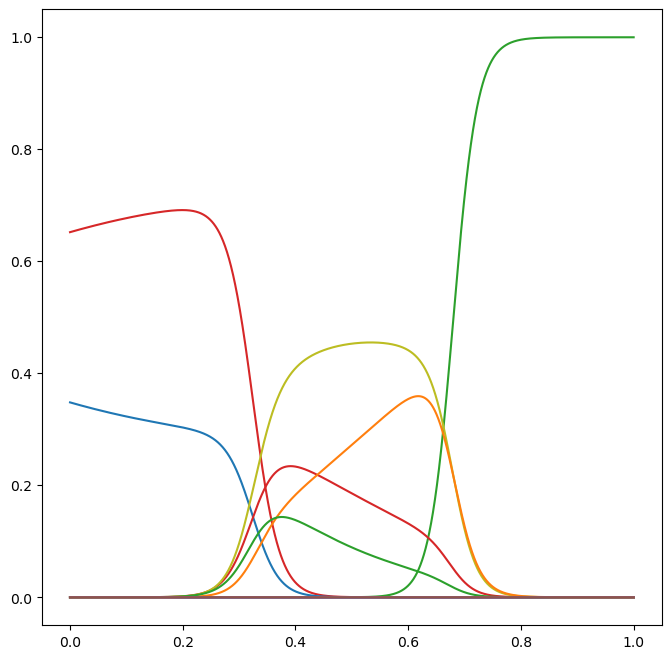

In [47]:
plt.figure(figsize=(8, 8), facecolor='white')
for pi_k, sigma_k in zip(pi_vals.T, var_vals.T):
    plt.plot(x_test, pi_k)
    # plt.fill_between(x_test, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
# plt.scatter(flipped_x, flipped_y, marker='.', lw=0, alpha=0.2, c='black')
plt.show()